- Convert HydroBASIN polygons from SHP to KML
- Fix geometry errors 
- Simplify geometry (optionally)

In [10]:
%matplotlib inline

import logging
import sys
import os
import glob

import math
import ogr
import shapely.geometry, shapely.wkt
import pylab
import matplotlib.pyplot as plt
from utils.shapely_plot import draw
import shapely as sl
import fiona
import numpy as np
import networkx as nx

pylab.rcParams['figure.figsize'] = (17.0, 15.0)
logging.basicConfig(stream=sys.stderr, level=logging.INFO)


In [11]:
info = {
    'sa' : { 
        'name': 'South America',
        'main_basin_id': 6010000010,
        'files': glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_sa_lev*_v1c.shp'),
        'pfaf_ids': range(61, 68)
    },
    'af' : { 
        'name': 'Africa',
        'main_basin_id': 1010000010,
        'files': glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_af_lev*_v1c.shp'),
        'pfaf_ids': range(11, 19)
    },
    'si' : { 
        'name': 'Siberia',
        'main_basin_id': 3010000010,
        'files': glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_si_lev*_v1c.shp'),
        'pfaf_ids': range(31, 37)
    },
    'eu' : { 
        'name': 'Europe and Middle East',
        'main_basin_id': 2010000010,
        'files': glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_eu_lev*_v1c.shp'),
        'pfaf_ids': range(21, 30)
    },
    'na' : { 
        'name': 'North America and Carribean',
        'main_basin_id': 7010000010,
        'files': glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_na_lev*_v1c.shp'),
        'pfaf_ids': range(71, 79)
    },
    'ar' : { 
        'name': 'North American Arctic',
        'main_basin_id': 8010000010,
        'files': glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_ar_lev*_v1c.shp'),
        'pfaf_ids': range(81, 87)
    },
    'ar2' : { 
        'name': 'North American Arctic 2',
        'main_basin_id': 8010020760,
        'files': glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_ar_lev*_v1c.shp'),
        'pfaf_ids': [3]
    },
    'as' : { 
        'name': 'Central and South-East Asia',
        'main_basin_id': 4010000010,
        'files': glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_as_lev*_v1c.shp'),
        'pfaf_ids': range(41, 50)
    },
    'au' : { 
        'name': 'Australia and Oceania',
        'main_basin_id': 5010000010,
        'files': glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_au_lev*_v1c.shp'),
        'pfaf_ids': range(51, 58)
    },
    'gr' : { 
        'name': 'Greenland',
        'main_basin_id': 9010000010,
        'files': glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_gr_lev*_v1c.shp'),
        'pfaf_ids': [91]
    },
}

# max_w = 4.0
# max_h = 4.0
# base_dir = '../output/basins_max_4/'

max_w = 12.0
max_h = 12.0
base_dir = '../output/basins_max_12/'

In [12]:
def get_basin(id, path):
    with fiona.collection(path, "r") as input:
        for f in input:
            if id == f['properties']['HYBAS_ID']:
                return f
    return None

def get_child_basins(parent_pfaf_id, child_basins_path):
    with fiona.collection(child_basins_path, "r") as input:
        for feature in input:
            pfaf_id = feature['properties']['PFAF_ID'] 
            if str(pfaf_id).startswith(str(parent_pfaf_id)): 
                yield feature

def get_children(main_basin_id, child_basins_path):
    print('Child basins: ' + child_basins_path)
    child_basins = list(get_child_basins(main_basin_id, child_basins_path))
    child_basins_ids = [str(f['properties']['PFAF_ID']) for f in child_basins]
    child_basins_geoms = [sl.geometry.shape(f['geometry']) for f in child_basins]
    count = len(child_basins)
    print(count)
    
    return (child_basins, child_basins_ids, child_basins_geoms)

def convert_basins_to_graph(region):
    n = nx.DiGraph()

    main_basin_id = region['main_basin_id']
    files = region['files']
    pfaf_ids = region['pfaf_ids']
    name = region['name']

    main_basin = get_basin(main_basin_id, files[0])

    pfaf_id = str(main_basin['properties']['PFAF_ID'])
    main_basin_geom = sl.geometry.shape(main_basin['geometry'])

    print('Main basin: ' + files[0])
    print('Main basin pfafid: ' + pfaf_id)
    print('Area: ' + str(main_basin_geom.area))

    basins2, ids2, geoms2 = get_children(pfaf_id, files[0])
    basins3, ids3, geoms3 = get_children(pfaf_id, files[1])
    basins4, ids4, geoms4 = get_children(pfaf_id, files[2])
    basins5, ids5, geoms5 = get_children(pfaf_id, files[3])
    basins6, ids6, geoms6 = get_children(pfaf_id, files[4])
    basins7, ids7, geoms7 = get_children(pfaf_id, files[5])
    basins8, ids8, geoms8 = get_children(pfaf_id, files[6])
    basins9, ids9, geoms9 = get_children(pfaf_id, files[7])

    basins_per_level = [basins2, basins3, basins4, basins5, basins6, basins7, basins8, basins9]

    ids = [pfaf_id]+ids2+ids3+ids4+ids5+ids6+ids7+ids8+ids9
    areas = [g.area for g in [main_basin_geom]+geoms2+geoms3+geoms4+geoms5+geoms6+geoms7+geoms8+geoms9]
    basins = [b for b in [main_basin]+basins2+basins3+basins4+basins5+basins6+basins7+basins8+basins9]

    print('Total basins: {0}'.format(len(basins)))
    
    n.add_nodes_from([(i,{'area':a, 'feature':f}) for (i,a,f) in zip(ids, areas, basins)])
    # n.add_nodes_from([(i,{'area':a}) for (i,a,f) in zip(ids, areas, basins)])

    n.add_edges_from([(pfaf_id, i) for i in ids2])
    n.add_edges_from([(i[:-1], i) for i in ids3])
    n.add_edges_from([(i[:-1], i) for i in ids4])
    n.add_edges_from([(i[:-1], i) for i in ids5])
    n.add_edges_from([(i[:-1], i) for i in ids6])
    n.add_edges_from([(i[:-1], i) for i in ids7])
    n.add_edges_from([(i[:-1], i) for i in ids8])
    n.add_edges_from([(i[:-1], i) for i in ids9])

    # max_level = 6
    # n = n.subgraph([kv[0] for kv in list(n.degree().iteritems()) if len(kv[0]) < max_level + 2])
    
    return n

def get_wh(geom):
    bounds = geom.bounds

    w = bounds[2]-bounds[0]
    h = bounds[3]-bounds[1]
    
    return (w, h) 

def geometry_larger_than(geom, w, h):
    bounds = geom.bounds
    gw = bounds[2]-bounds[0]
    gh = bounds[3]-bounds[1]
    return (gw > w) or (gh > h)

def geometry_smaller_than(geom, w, h):
    bounds = geom.bounds
    gw = bounds[2]-bounds[0]
    gh = bounds[3]-bounds[1]
    return (gw < w) and (gh < h)

def get_leaves_smaller_than(graph, graph_nodes, node, w, h):
    for child_node in graph.successors(node):
        geom = sl.geometry.shape(graph_nodes[child_node]['feature']['geometry'])
        
        last = len(graph.successors(child_node)) == 0
    
        if(geometry_smaller_than(geom, w, h) or last):
            yield child_node
        else:
            for child_child_node in get_leaves_smaller_than(graph, graph_nodes, child_node, w, h):
                yield child_child_node

                
def get_leaf_basins(graph, graph_nodes, pfaf_id, max_w, max_h):
    """Returns leaf basins smaller than max_w, max_h"""
    leaves = list(get_leaves_smaller_than(graph, graph_nodes, str(pfaf_id), max_w, max_h))
    print(len(leaves))
    s = graph.subgraph(leaves)
    return s                

def write_basins(region_id, info, pfaf_id, basins, file_name=None, mode='w'):
    with fiona.open(info['files'][0]) as source:
        source_driver = source.driver
        source_crs = source.crs
        source_schema = source.schema

    # strange bug? values are not written unless we add .1
    source_schema['properties']['HYBAS_ID'] = 'float:11.1'
    source_schema['properties']['NEXT_DOWN'] = 'float:11.1'
    source_schema['properties']['NEXT_SINK'] = 'float:11.1'
    source_schema['properties']['MAIN_BAS'] = 'float:11.1'

    if not file_name:
        file_name = base_dir  + '/hybas_' + region_id + '_PFAF' + str(pfaf_id) + '_v1c.shp'
    print('Writing ' + file_name)
    
    with fiona.open(file_name, mode, driver=source_driver, crs=source_crs, schema=source_schema) as c:
        for node in basins:
            feature = node[1]['feature']

            geom = sl.geometry.shape(feature['geometry'])
            if not geom.is_valid:
                clean = geom.buffer(0.0) # Use the 0-buffer polygon cleaning trick
                assert clean.is_valid
                geom = clean
                feature['geometry'] = sl.geometry.mapping(geom)
                
            c.write(feature)


In [18]:
first = True
for i in info:
    region_id = i
    region_info = info[i]
    
    print('Region: ' + region_id)
    
    graph = convert_basins_to_graph(region_info)
    graph_nodes=dict(graph.nodes(data=True))

    for pfaf_id in region_info['pfaf_ids']:
        basins = get_leaf_basins(graph, graph_nodes, pfaf_id, max_w, max_h).nodes(data=True)
        if first:
            mode = 'w'
        else:
            mode = 'a'
        # write_basins(region_id, region_info, pfaf_id, basins, base_dir + 'all.shp', mode)
        write_basins(region_id, region_info, pfaf_id, basins)
        first=False

Region: ar2
Main basin: D:\gis\HydroBASINS\without_lakes\hybas_ar_lev01_v1c.shp
Main basin pfafid: 3
Area: 23.978013577279903
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_ar_lev01_v1c.shp
1
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_ar_lev02_v1c.shp
1
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_ar_lev03_v1c.shp
1
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_ar_lev04_v1c.shp
1
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_ar_lev05_v1c.shp
2
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_ar_lev06_v1c.shp
2
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_ar_lev07_v1c.shp
10
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_ar_lev08_v1c.shp


Ring Self-intersection at or near point -172.30833333333331 65.666666666666686
Ring Self-intersection at or near point -172.30833333333331 65.666666666666686


75
Total basins: 94
2
Writing ../output/basins_max_12//hybas_ar2_PFAF3_v1c.shp
Region: na
Main basin: D:\gis\HydroBASINS\without_lakes\hybas_na_lev01_v1c.shp
Main basin pfafid: 7
Area: 1777.5516322922588
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_na_lev01_v1c.shp
1
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_na_lev02_v1c.shp
8
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_na_lev03_v1c.shp
29
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_na_lev04_v1c.shp
185
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_na_lev05_v1c.shp
624
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_na_lev06_v1c.shp
2043
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_na_lev07_v1c.shp
6938
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_na_lev08_v1c.shp
22533
Total basins: 32362


Ring Self-intersection at or near point -97.833333333333314 52.52916666666669
Ring Self-intersection at or near point -81.399999999999977 52.141666666666687


55
Writing ../output/basins_max_12//hybas_na_PFAF71_v1c.shp


Ring Self-intersection at or near point -96.445833333333297 55.754166666666698
Ring Self-intersection at or near point -83.408333333333303 47.79583333333337
Ring Self-intersection at or near point -82.670833333333306 55.170833333333363
Ring Self-intersection at or near point -111.39166666666664 54.170833333333356
Ring Self-intersection at or near point -90.391666666666637 57.183333333333358
Ring Self-intersection at or near point -109.32499999999997 55.133333333333361
Ring Self-intersection at or near point -58.349999999999973 49.108333333333363


41
Writing ../output/basins_max_12//hybas_na_PFAF72_v1c.shp


Ring Self-intersection at or near point -60.720833333333303 50.21250000000002
Ring Self-intersection at or near point -57.879166666666634 54.804166666666688
Ring Self-intersection at or near point -64.51249999999996 60.391666666666673
Ring Self-intersection at or near point -68.537499999999966 58.866666666666696
Ring Self-intersection at or near point -69.354166666666643 59.216666666666697
Ring Self-intersection at or near point -78.77916666666664 52.850000000000023
Ring Self-intersection at or near point -59.41249999999998 50.620833333333358
Ring Self-intersection at or near point -78.624999999999972 58.800000000000026
Ring Self-intersection at or near point -75.770833333333314 48.045833333333356
Ring Self-intersection at or near point -68.016666666666652 48.670833333333356
Ring Self-intersection at or near point -78.866666666666632 51.937500000000036
Ring Self-intersection at or near point -79.649999999999977 51.970833333333353
Ring Self-intersection at or near point -84.941666666666

19
Writing ../output/basins_max_12//hybas_na_PFAF73_v1c.shp


Ring Self-intersection at or near point -80.899999999999963 32.050000000000018
Ring Self-intersection at or near point -69.854166666666643 43.741666666666703
Ring Self-intersection at or near point -72.349999999999966 41.091666666666697
Ring Self-intersection at or near point -88.3958333333333 30.379166666666688
Ring Self-intersection at or near point -76.03749999999998 39.554166666666696
Ring Self-intersection at or near point -85.229166666666643 29.687500000000032
Ring Self-intersection at or near point -76.829166666666637 38.350000000000023
Ring Self-intersection at or near point -75.816666666666649 36.270833333333357
Ring Self-intersection at or near point -89.770833333333314 29.387500000000031


45
Writing ../output/basins_max_12//hybas_na_PFAF74_v1c.shp


Ring Self-intersection at or near point -96.466666666666626 44.445833333333354
Ring Self-intersection at or near point -89.979166666666629 46.270833333333357
Ring Self-intersection at or near point -89.408333333333303 30.041666666666686
Ring Self-intersection at or near point -81.837499999999977 9.1125000000000238


23
Writing ../output/basins_max_12//hybas_na_PFAF75_v1c.shp


Ring Self-intersection at or near point -96.408333333333303 28.633333333333358
Ring Self-intersection at or near point -102.68749999999997 27.375000000000028
Ring Self-intersection at or near point -97.566666666666634 24.975000000000026
Ring Self-intersection at or near point -97.608333333333306 21.716666666666683
Ring Self-intersection at or near point -90.445833333333297 20.704166666666691
Ring Self-intersection at or near point -77.045833333333306 17.858333333333366
Ring Self-intersection at or near point -77.991666666666632 25.087500000000027


5
Writing ../output/basins_max_12//hybas_na_PFAF76_v1c.shp


Ring Self-intersection at or near point -80.254166666666634 23.025000000000027
Ring Self-intersection at or near point -70.858333333333306 18.329166666666687
Ring Self-intersection at or near point -65.629166666666634 18.220833333333353
Ring Self-intersection at or near point -124.18749999999997 41.737500000000033
Ring Self-intersection at or near point -96.091666666666626 15.766666666666699
Ring Self-intersection at or near point -85.879166666666649 11.254166666666691


49
Writing ../output/basins_max_12//hybas_na_PFAF77_v1c.shp


Ring Self-intersection at or near point -112.8958333333333 30.454166666666691
Ring Self-intersection at or near point -101.55833333333331 17.625000000000032
Ring Self-intersection at or near point -111.58749999999998 24.425000000000022
Ring Self-intersection at or near point -87.429166666666646 13.358333333333363
Ring Self-intersection at or near point -94.2083333333333 16.162500000000019
Ring Self-intersection at or near point -122.93749999999997 38.041666666666686
Ring Self-intersection at or near point -109.42083333333331 25.908333333333353
Ring Self-intersection at or near point -114.03749999999997 27.745833333333366
Ring Self-intersection at or near point -109.06666666666663 25.550000000000033
Ring Self-intersection at or near point -105.08749999999998 19.520833333333364
Ring Self-intersection at or near point -123.3458333333333 45.4166666666667
Ring Self-intersection at or near point -123.79999999999998 50.795833333333356


20
Writing ../output/basins_max_12//hybas_na_PFAF78_v1c.shp


Ring Self-intersection at or near point -122.5333333333333 48.470833333333353
Ring Self-intersection at or near point -123.75416666666665 46.208333333333357
Ring Self-intersection at or near point -132.54999999999998 56.662500000000023
Ring Self-intersection at or near point -130.16666666666666 54.125000000000021
Ring Self-intersection at or near point -123.96249999999998 49.504166666666698
Ring Self-intersection at or near point -130.78749999999999 54.829166666666694
Ring Self-intersection at or near point -132.36249999999998 53.029166666666697


Region: eu
Main basin: D:\gis\HydroBASINS\without_lakes\hybas_eu_lev01_v1c.shp
Main basin pfafid: 2
Area: 2216.9698091841606
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_eu_lev01_v1c.shp
1
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_eu_lev02_v1c.shp
9
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_eu_lev03_v1c.shp
50
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_eu_lev04_v1c.shp
240
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_eu_lev05_v1c.shp
674
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_eu_lev06_v1c.shp
2240
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_eu_lev07_v1c.shp
7820
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_eu_lev08_v1c.shp
25315
Total basins: 36350


Ring Self-intersection at or near point 9.4083333333333599 41.208333333333364
Ring Self-intersection at or near point 23.995833333333348 35.516666666666694


29
Writing ../output/basins_max_12//hybas_eu_PFAF21_v1c.shp


Ring Self-intersection at or near point 2.3833333333333524 39.529166666666697
Ring Self-intersection at or near point 24.02083333333335 37.879166666666698
Ring Self-intersection at or near point 14.416666666666686 42.350000000000023
Ring Self-intersection at or near point 35.66250000000003 36.71666666666669
Ring Self-intersection at or near point 28.029166666666683 36.666666666666693
Ring Self-intersection at or near point 12.466666666666686 37.875000000000036
Ring Self-intersection at or near point 14.454166666666703 40.745833333333358
Ring Self-intersection at or near point 13.587500000000029 45.183333333333358
Ring Self-intersection at or near point -0.75833333333330755 37.800000000000033
Ring Self-intersection at or near point 2.1666666666666838 41.34583333333336
Ring Self-intersection at or near point 33.320833333333361 31.195833333333361


41
Writing ../output/basins_max_12//hybas_eu_PFAF22_v1c.shp


Ring Self-intersection at or near point 33.420833333333363 44.59166666666669
Ring Self-intersection at or near point 29.679166666666696 45.466666666666697
Ring Self-intersection at or near point 36.495833333333351 50.816666666666691
Ring Self-intersection at or near point 27.570833333333361 42.450000000000024
Ring Self-intersection at or near point 9.4416666666666949 53.716666666666697


15
Writing ../output/basins_max_12//hybas_eu_PFAF23_v1c.shp


Ring Self-intersection at or near point -1.2124999999999777 60.462500000000006
Ring Self-intersection at or near point 4.1458333333333508 51.958333333333371
Ring Self-intersection at or near point 3.4083333333333603 47.266666666666694
Ring Self-intersection at or near point -6.7083333333333064 62.225000000000009
Ring Self-intersection at or near point -8.4124999999999712 43.375000000000028
Ring Self-intersection at or near point -0.6791666666666405 45.083333333333364
Ring Self-intersection at or near point -9.670833333333313 53.333333333333364
Ring Self-intersection at or near point 1.2500000000000258 51.887500000000031
Ring Self-intersection at or near point -4.6124999999999723 48.583333333333357
Ring Self-intersection at or near point 18.845833333333356 59.583333333333364


37
Writing ../output/basins_max_12//hybas_eu_PFAF24_v1c.shp


Ring Self-intersection at or near point 31.129166666666691 56.266666666666687
Ring Self-intersection at or near point 21.175000000000026 62.541666666666679
Ring Self-intersection at or near point 26.175000000000015 55.370833333333366
Ring Self-intersection at or near point 12.10833333333335 57.833333333333364
Ring Self-intersection at or near point 33.09583333333336 62.895833333333343
Ring Self-intersection at or near point 18.800000000000022 57.550000000000033
Ring Self-intersection at or near point 17.650000000000031 62.433333333333344
Ring Self-intersection at or near point 24.545833333333352 50.191666666666684
Ring Self-intersection at or near point 23.479166666666693 58.804166666666688
Ring Self-intersection at or near point 28.708333333333353 60.725000000000009
Ring Self-intersection at or near point 18.766666666666691 63.233333333333348
Ring Self-intersection at or near point 11.533333333333362 57.941666666666684
Ring Self-intersection at or near point 14.091666666666685 53.3458

35
Writing ../output/basins_max_12//hybas_eu_PFAF25_v1c.shp


Ring Self-intersection at or near point 10.758333333333354 59.304166666666696
Ring Self-intersection at or near point 26.991666666666706 80.083333333333343
Ring Self-intersection at or near point 10.366666666666685 59.133333333333361
Ring Self-intersection at or near point 12.52500000000002 79.758333333333354
Ring Self-intersection at or near point 9.2583333333333595 63.51666666666668
Ring Self-intersection at or near point 20.850000000000023 77.541666666666686
Ring Self-intersection at or near point 24.225000000000016 70.608333333333348
Ring Self-intersection at or near point 29.825000000000031 69.783333333333346
Ring Self-intersection at or near point 12.708333333333355 65.808333333333351
Ring Self-intersection at or near point 11.033333333333356 59.150000000000027
Ring Self-intersection at or near point 35.833333333333364 65.033333333333346
Ring Self-intersection at or near point 56.675000000000018 74.683333333333337
Ring Self-intersection at or near point 56.475000000000016 73.7250

68
Writing ../output/basins_max_12//hybas_eu_PFAF26_v1c.shp


Ring Self-intersection at or near point 40.450000000000017 64.75833333333334
Ring Self-intersection at or near point 56.0416666666667 70.63333333333334
Ring Self-intersection at or near point 60.71666666666669 69.616666666666688
Ring Self-intersection at or near point 54.158333333333353 68.075000000000003
Ring Self-intersection at or near point 45.9791666666667 66.82916666666668
Ring Self-intersection at or near point 48.71250000000002 65.95416666666668
Ring Self-intersection at or near point 66.27500000000002 76.591666666666683
Ring Self-intersection at or near point 48.133333333333347 80.191666666666677
Ring Self-intersection at or near point 49.970833333333346 67.745833333333351
Ring Self-intersection at or near point 54.995833333333358 62.720833333333346
Ring Self-intersection at or near point -14.474999999999973 64.791666666666671


2
Writing ../output/basins_max_12//hybas_eu_PFAF27_v1c.shp


Ring Self-intersection at or near point 47.479166666666693 45.325000000000031


55
Writing ../output/basins_max_12//hybas_eu_PFAF28_v1c.shp


Ring Self-intersection at or near point 52.71250000000002 46.77916666666669
Ring Self-intersection at or near point 55.462500000000027 46.887500000000024
Ring Self-intersection at or near point 49.962500000000034 37.445833333333361
Ring Self-intersection at or near point 51.308333333333358 44.608333333333356
Ring Self-intersection at or near point 49.337500000000027 39.420833333333363
Ring Self-intersection at or near point 55.516666666666694 41.404166666666697
Ring Self-intersection at or near point 53.204166666666694 46.612500000000026
Ring Self-intersection at or near point 38.829166666666687 58.108333333333356
Ring Self-intersection at or near point 49.170833333333356 39.137500000000031
Ring Self-intersection at or near point 53.591666666666697 39.6041666666667
Ring Self-intersection at or near point 48.291666666666686 45.458333333333364
Ring Self-intersection at or near point 53.625000000000028 39.979166666666686
Ring Self-intersection at or near point 52.550000000000018 56.604166

59
Writing ../output/basins_max_12//hybas_eu_PFAF29_v1c.shp


Ring Self-intersection at or near point 54.095833333333346 24.245833333333355
Ring Self-intersection at or near point 48.862500000000026 27.612500000000033
Ring Self-intersection at or near point 39.120833333333358 21.337500000000031
Ring Self-intersection at or near point 52.195833333333347 15.8166666666667
Ring Self-intersection at or near point 33.254166666666691 28.550000000000022
Ring Self-intersection at or near point 48.45833333333335 29.991666666666703
Ring Self-intersection at or near point 55.708333333333364 26.854166666666693
Ring Self-intersection at or near point 55.53333333333336 20.987500000000026
Ring Self-intersection at or near point 56.062500000000014 27.091666666666693
Ring Self-intersection at or near point 55.483333333333363 18.183333333333355
Ring Self-intersection at or near point 48.958333333333357 30.283333333333353
Ring Self-intersection at or near point 54.562500000000021 32.420833333333356
Ring Self-intersection at or near point 55.066666666666691 21.816666

Region: sa
Main basin: D:\gis\HydroBASINS\without_lakes\hybas_sa_lev01_v1c.shp
Main basin pfafid: 6
Area: 1548.5675318339918
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_sa_lev01_v1c.shp
1
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_sa_lev02_v1c.shp
7
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_sa_lev03_v1c.shp
31
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_sa_lev04_v1c.shp
147
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_sa_lev05_v1c.shp
496
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_sa_lev06_v1c.shp
1946
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_sa_lev07_v1c.shp
7036
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_sa_lev08_v1c.shp
23783
Total basins: 33448

Ring Self-intersection at or near point -53.904166666666654 5.7416666666666956
Ring Self-intersection at or near point -61.670833333333306 10.695833333333354
Ring Self-intersection at or near point -64.629166666666634 10.250000000000018



30
Writing ../output/basins_max_12//hybas_sa_PFAF61_v1c.shp


Ring Self-intersection at or near point -54.029166666666633 5.6083333333333609
Ring Self-intersection at or near point -65.15416666666664 10.075000000000015
Ring Self-intersection at or near point -74.112499999999969 11.333333333333359
Ring Self-intersection at or near point -58.579166666666637 6.7416666666666885
Ring Self-intersection at or near point -71.754166666666649 9.1208333333333584
Ring Self-intersection at or near point -77.991666666666632 9.1958333333333577
Ring Self-intersection at or near point -60.808333333333302 8.8750000000000213


77
Writing ../output/basins_max_12//hybas_sa_PFAF62_v1c.shp


Ring Self-intersection at or near point -63.937499999999979 -8.3333333333333037
Ring Self-intersection at or near point -63.474999999999973 -0.91666666666664165
Ring Self-intersection at or near point -51.008333333333312 -0.57916666666663907
Ring Self-intersection at or near point -67.254166666666634 -5.7583333333333151
Ring Self-intersection at or near point -69.162499999999966 -14.762499999999974
Ring Self-intersection at or near point -49.28749999999998 -2.0333333333333172
Ring Self-intersection at or near point -49.362499999999983 -1.5874999999999804
Ring Self-intersection at or near point -37.16249999999998 -11.099999999999977


21
Writing ../output/basins_max_12//hybas_sa_PFAF63_v1c.shp


Ring Self-intersection at or near point -44.954166666666644 -23.383333333333312
Ring Self-intersection at or near point -35.087499999999977 -8.6916666666666398
Ring Self-intersection at or near point -43.437499999999979 -2.4208333333333045
Ring Self-intersection at or near point -42.370833333333309 -15.070833333333312
Ring Self-intersection at or near point -58.079166666666637 -32.916666666666636
Ring Self-intersection at or near point -58.40416666666664 -34.262499999999967


29
Writing ../output/basins_max_12//hybas_sa_PFAF64_v1c.shp


Ring Self-intersection at or near point -50.649999999999977 -30.199999999999967
Ring Self-intersection at or near point -57.074999999999974 -28.629166666666638
Ring Self-intersection at or near point -54.345833333333303 -34.616666666666639
Ring Self-intersection at or near point -45.887499999999982 -22.795833333333302
Ring Self-intersection at or near point -58.137499999999967 -33.037499999999973
Ring Self-intersection at or near point -65.883333333333312 -45.045833333333306
Ring Self-intersection at or near point -58.941666666666642 -51.841666666666647


22
Writing ../output/basins_max_12//hybas_sa_PFAF65_v1c.shp


Ring Self-intersection at or near point -62.187499999999964 -38.854166666666636
Ring Self-intersection at or near point -65.870833333333309 -47.795833333333313
Ring Self-intersection at or near point -62.041666666666629 -40.254166666666634
Ring Self-intersection at or near point -73.158333333333303 -37.02916666666664
Ring Self-intersection at or near point -70.854166666666629 -27.079166666666641
Ring Self-intersection at or near point -73.53749999999998 -45.204166666666644


25
Writing ../output/basins_max_12//hybas_sa_PFAF66_v1c.shp


Ring Self-intersection at or near point -73.116666666666632 -41.812499999999979
Ring Self-intersection at or near point -73.46666666666664 -47.866666666666646
Ring Self-intersection at or near point -71.174999999999969 -28.095833333333299
Ring Self-intersection at or near point -72.954166666666637 -52.970833333333303
Ring Self-intersection at or near point -72.837499999999963 -45.424999999999976
Ring Self-intersection at or near point -70.570833333333297 -54.112499999999969
Ring Self-intersection at or near point -89.958333333333314 0.30416666666668535
Ring Self-intersection at or near point -77.533333333333303 3.2250000000000258
Ring Self-intersection at or near point -78.429166666666632 -9.3458333333333119


20
Writing ../output/basins_max_12//hybas_sa_PFAF67_v1c.shp


Ring Self-intersection at or near point -80.383333333333297 -3.4874999999999798
Ring Self-intersection at or near point -78.566666666666634 2.4375000000000195
Ring Self-intersection at or near point -77.504166666666634 4.2000000000000171
Ring Self-intersection at or near point -80.008333333333312 -2.5999999999999726


Region: si
Main basin: D:\gis\HydroBASINS\without_lakes\hybas_si_lev01_v1c.shp
Main basin pfafid: 3
Area: 2287.0694512168793
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_si_lev01_v1c.shp
1
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_si_lev02_v1c.shp
6
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_si_lev03_v1c.shp
18
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_si_lev04_v1c.shp
72
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_si_lev05_v1c.shp
408
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_si_lev06_v1c.shp
1506
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_si_lev07_v1c.shp
5442
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_si_lev08_v1c.shp
18265
Total basins: 25719
53
Writing ../output/basins_max_12//hybas_si_PFAF31_v1c.shp


Ring Self-intersection at or near point 69.879166666666691 60.812500000000014
Ring Self-intersection at or near point 60.366666666666681 55.766666666666701
Ring Self-intersection at or near point 72.250000000000028 66.25833333333334
Ring Self-intersection at or near point 68.266666666666694 68.208333333333343
Ring Self-intersection at or near point 75.208333333333371 57.229166666666693
Ring Self-intersection at or near point 70.05000000000004 66.575000000000003
Ring Self-intersection at or near point 81.741666666666688 54.687500000000021
Ring Self-intersection at or near point 91.750000000000043 57.704166666666701
Ring Self-intersection at or near point 62.737500000000018 61.720833333333353
Ring Self-intersection at or near point 75.100000000000037 55.004166666666691
Ring Self-intersection at or near point 82.9166666666667 70.691666666666677


59
Writing ../output/basins_max_12//hybas_si_PFAF32_v1c.shp


Ring Self-intersection at or near point 86.520833333333357 68.145833333333343
Ring Self-intersection at or near point 95.316666666666706 59.558333333333366
Ring Self-intersection at or near point 83.983333333333377 69.783333333333346


99
Writing ../output/basins_max_12//hybas_si_PFAF33_v1c.shp


Ring Self-intersection at or near point 112.55000000000003 76.616666666666674
Ring Self-intersection at or near point 96.02500000000002 76.975000000000009
Ring Self-intersection at or near point 119.56666666666671 73.050000000000011
Ring Self-intersection at or near point 102.75833333333335 78.208333333333343
Ring Self-intersection at or near point 106.87083333333337 73.08750000000002
Ring Self-intersection at or near point 87.958333333333371 72.254166666666677
Ring Self-intersection at or near point 103.43750000000003 72.337500000000006
Ring Self-intersection at or near point 120.01666666666669 73.091666666666683
Ring Self-intersection at or near point 82.90833333333336 75.950000000000017
Ring Self-intersection at or near point 93.358333333333363 79.816666666666691
Ring Self-intersection at or near point 105.14583333333337 73.40000000000002
Ring Self-intersection at or near point 86.841666666666697 73.991666666666674
Ring Self-intersection at or near point 128.08333333333334 66.395833

51
Writing ../output/basins_max_12//hybas_si_PFAF34_v1c.shp


Ring Self-intersection at or near point 121.76250000000003 65.183333333333351
Ring Self-intersection at or near point 129.87500000000003 71.100000000000009
Ring Self-intersection at or near point 112.7916666666667 64.395833333333343
Ring Self-intersection at or near point 129.35000000000002 72.76666666666668
Ring Self-intersection at or near point 179.39166666666668 70.858333333333348
Ring Self-intersection at or near point 172.26666666666668 61.125000000000014


125
Writing ../output/basins_max_12//hybas_si_PFAF35_v1c.shp


Ring Self-intersection at or near point 160.15833333333336 69.700000000000017
Ring Self-intersection at or near point 142.97916666666669 60.76250000000001
Ring Self-intersection at or near point 148.85000000000002 68.82916666666668
Ring Self-intersection at or near point 173.37916666666669 64.637500000000003
Ring Self-intersection at or near point 140.08333333333337 72.25
Ring Self-intersection at or near point 153.34583333333336 59.116666666666696
Ring Self-intersection at or near point 163.19583333333335 59.520833333333364
Ring Self-intersection at or near point 177.60833333333335 51.945833333333354
Ring Self-intersection at or near point 161.8416666666667 69.616666666666688
Ring Self-intersection at or near point 137.20000000000002 71.533333333333346
Ring Self-intersection at or near point 146.98750000000001 71.737500000000011
Ring Self-intersection at or near point 173.70416666666668 52.425000000000026


1
Writing ../output/basins_max_12//hybas_si_PFAF36_v1c.shp
Region: au
Main basin: D:\gis\HydroBASINS\without_lakes\hybas_au_lev01_v1c.shp
Main basin pfafid: 5
Area: 971.3741464955751
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_au_lev01_v1c.shp
1
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_au_lev02_v1c.shp
7
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_au_lev03_v1c.shp
47
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_au_lev04_v1c.shp
143
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_au_lev05_v1c.shp
457
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_au_lev06_v1c.shp
1425
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_au_lev07_v1c.shp
4670
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_au_lev08_v1c.shp
15233
Total basins: 21984


Ring Self-intersection at or near point 131.66666666666671 -7.4166666666666456
Ring Self-intersection at or near point 102.9666666666667 0.6541666666666881
Ring Self-intersection at or near point 119.77083333333337 -8.662499999999973


23
Writing ../output/basins_max_12//hybas_au_PFAF51_v1c.shp


Ring Self-intersection at or near point 95.895833333333371 5.4250000000000265
Ring Self-intersection at or near point 107.43750000000003 -2.9291666666666418
Ring Self-intersection at or near point 98.795833333333363 1.5750000000000286
Ring Self-intersection at or near point 99.2916666666667 -1.6458333333333144
Ring Self-intersection at or near point 104.47083333333336 1.0250000000000243
Ring Self-intersection at or near point 105.77083333333337 -5.8541666666666492
Ring Self-intersection at or near point 104.61250000000003 -1.999999999999984
Ring Self-intersection at or near point 113.7291666666667 -8.5208333333333055
Ring Self-intersection at or near point 103.53750000000004 0.44166666666668641
Ring Self-intersection at or near point 123.53333333333337 -5.3708333333333123
Ring Self-intersection at or near point 123.17083333333336 -1.6374999999999811
Ring Self-intersection at or near point 120.62500000000003 -7.0999999999999766
Ring Self-intersection at or near point 122.88750000000003 

23
Writing ../output/basins_max_12//hybas_au_PFAF52_v1c.shp


Ring Self-intersection at or near point 122.3416666666667 -4.9083333333333083
Ring Self-intersection at or near point 124.35833333333336 -1.7499999999999818
Ring Self-intersection at or near point 122.00833333333335 -0.35416666666663721
Ring Self-intersection at or near point 121.38333333333337 13.245833333333362
Ring Self-intersection at or near point 122.32083333333335 -3.3791666666666456
Ring Self-intersection at or near point 122.02500000000003 15.020833333333361
Ring Self-intersection at or near point 106.23333333333336 3.3208333333333599
Ring Self-intersection at or near point 124.06666666666671 13.233333333333363
Ring Self-intersection at or near point 125.57916666666671 11.187500000000025
Ring Self-intersection at or near point 117.26666666666669 8.4041666666666845
Ring Self-intersection at or near point 121.99583333333337 6.7416666666666885
Ring Self-intersection at or near point 109.9291666666667 -1.7708333333333153
Ring Self-intersection at or near point 125.62500000000003 3

25
Writing ../output/basins_max_12//hybas_au_PFAF53_v1c.shp


Ring Self-intersection at or near point 135.48333333333335 -0.77083333333330728
Ring Self-intersection at or near point 127.81666666666671 -3.1666666666666439
Ring Self-intersection at or near point 153.41666666666669 -11.549999999999979
Ring Self-intersection at or near point 140.34166666666667 -2.4583333333333046
Ring Self-intersection at or near point 138.91250000000002 -7.8916666666666497
Ring Self-intersection at or near point 128.65833333333336 0.55000000000002069
Ring Self-intersection at or near point 134.73333333333335 -3.94166666666665
Ring Self-intersection at or near point 150.65000000000001 -10.587499999999972
Ring Self-intersection at or near point 149.72500000000002 -5.5458333333333139
Ring Self-intersection at or near point 130.3416666666667 -0.099999999999968558
Ring Self-intersection at or near point 149.875 -10.562499999999972
Ring Self-intersection at or near point 142.28750000000002 -9.1958333333333115
Ring Self-intersection at or near point 143.75000000000003 -7.5

5
Writing ../output/basins_max_12//hybas_au_PFAF54_v1c.shp


Ring Self-intersection at or near point 134.5625 7.345833333333343
Ring Self-intersection at or near point 166.07083333333335 -22.008333333333315
Ring Self-intersection at or near point 167.20833333333334 -15.570833333333315
Ring Self-intersection at or near point 177.93750000000003 -18.266666666666637


14
Writing ../output/basins_max_12//hybas_au_PFAF55_v1c.shp


Ring Self-intersection at or near point 166.92916666666667 -11.666666666666648
Ring Self-intersection at or near point 168.17500000000001 -17.712499999999984
Ring Self-intersection at or near point 122.10833333333336 -34.004166666666649


99
Writing ../output/basins_max_12//hybas_au_PFAF56_v1c.shp


Ring Self-intersection at or near point 147.86250000000001 -43.141666666666637
Ring Self-intersection at or near point 137.92500000000001 -32.754166666666634
Ring Self-intersection at or near point 117.75833333333337 -34.64999999999997
Ring Self-intersection at or near point 143.23750000000001 -11.991666666666649
Ring Self-intersection at or near point 118.20833333333336 -35.004166666666642
Ring Self-intersection at or near point 124.31666666666669 -16.458333333333307
Interior is disconnected at or near point 139.57083333333335 -36.049999999999969
Ring Self-intersection at or near point 116.60000000000002 -20.691666666666638
Ring Self-intersection at or near point 145.20416666666668 -38.308333333333302
Ring Self-intersection at or near point 148.87083333333334 -20.866666666666639
Ring Self-intersection at or near point 113.57500000000003 -26.574999999999971
Ring Self-intersection at or near point 153.17500000000001 -27.399999999999977
Ring Self-intersection at or near point 151.3208333

5
Writing ../output/basins_max_12//hybas_au_PFAF57_v1c.shp


Ring Self-intersection at or near point 174.80833333333334 -41.308333333333309


Region: as
Main basin: D:\gis\HydroBASINS\without_lakes\hybas_as_lev01_v1c.shp
Main basin pfafid: 4
Area: 2099.22069712002
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_as_lev01_v1c.shp
1
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_as_lev02_v1c.shp
9
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_as_lev03_v1c.shp
45
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_as_lev04_v1c.shp
199
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_as_lev05_v1c.shp
711
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_as_lev06_v1c.shp
2489
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_as_lev07_v1c.shp
8811
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_as_lev08_v1c.shp
28907
Total basins: 41173


Ring Self-intersection at or near point 148.51250000000002 45.275000000000027
Ring Self-intersection at or near point 128.13333333333335 26.595833333333356
Ring Self-intersection at or near point 130.98750000000004 30.729166666666693


13
Writing ../output/basins_max_12//hybas_as_PFAF41_v1c.shp


Ring Self-intersection at or near point 133.24583333333334 33.295833333333363
Ring Self-intersection at or near point 129.43750000000003 34.700000000000024
Ring Self-intersection at or near point 141.87500000000003 39.200000000000031
Ring Self-intersection at or near point 130.35416666666669 32.358333333333356
Ring Self-intersection at or near point 142.13333333333335 27.675000000000033
Ring Self-intersection at or near point 142.59166666666667 54.254166666666691
Ring Self-intersection at or near point 121.60000000000004 39.254166666666698
Ring Self-intersection at or near point 135.22916666666669 43.683333333333366


56
Writing ../output/basins_max_12//hybas_as_PFAF42_v1c.shp


Ring Self-intersection at or near point 120.99583333333337 40.84583333333336
Ring Self-intersection at or near point 141.08333333333334 52.97083333333336
Ring Self-intersection at or near point 140.35833333333335 48.995833333333358
Ring Self-intersection at or near point 140.82083333333335 51.491666666666696
Ring Self-intersection at or near point 124.54583333333336 39.720833333333367
Ring Self-intersection at or near point 131.48333333333338 42.983333333333363
Ring Self-intersection at or near point 127.43750000000003 38.741666666666688
Ring Self-intersection at or near point 127.30000000000003 34.445833333333354
Ring Self-intersection at or near point 126.00833333333335 42.129166666666684
Ring Self-intersection at or near point 122.00416666666669 36.962500000000027


50
Writing ../output/basins_max_12//hybas_as_PFAF43_v1c.shp


Ring Self-intersection at or near point 110.57916666666669 19.150000000000027
Ring Self-intersection at or near point 118.09583333333336 28.962500000000027
Ring Self-intersection at or near point 113.57500000000003 22.820833333333358
Ring Self-intersection at or near point 113.37083333333337 22.137500000000021
Ring Self-intersection at or near point 105.47083333333336 21.125000000000028
Ring Self-intersection at or near point 120.51666666666669 24.283333333333353
Ring Self-intersection at or near point 114.32500000000003 22.512500000000024
Ring Self-intersection at or near point 119.2166666666667 25.283333333333363
Ring Self-intersection at or near point 119.27500000000003 25.487500000000033
Ring Self-intersection at or near point 119.00833333333337 39.200000000000031
Ring Self-intersection at or near point 92.945833333333368 13.020833333333361
Ring Self-intersection at or near point 97.616666666666703 16.541666666666689
Ring Self-intersection at or near point 109.4041666666667 12.6416

72
Writing ../output/basins_max_12//hybas_as_PFAF44_v1c.shp


Ring Self-intersection at or near point 103.4666666666667 4.2500000000000178
Ring Self-intersection at or near point 103.86250000000004 1.4250000000000274
Ring Self-intersection at or near point 97.47083333333336 16.504166666666691
Ring Self-intersection at or near point 99.491666666666703 7.3375000000000261
Ring Self-intersection at or near point 94.662500000000023 16.120833333333351
Ring Self-intersection at or near point 98.145833333333357 12.183333333333353
Ring Self-intersection at or near point 100.85000000000002 12.758333333333358
Ring Self-intersection at or near point 96.820833333333368 16.954166666666694
Ring Self-intersection at or near point 97.808333333333366 14.966666666666693
Ring Self-intersection at or near point 105.87500000000004 10.083333333333366


57
Writing ../output/basins_max_12//hybas_as_PFAF45_v1c.shp


Ring Self-intersection at or near point 68.637500000000031 23.179166666666696
Ring Self-intersection at or near point 80.270833333333357 9.4916666666666938
Ring Self-intersection at or near point 90.65833333333336 22.791666666666693
Ring Self-intersection at or near point 76.662500000000023 20.262500000000021
Ring Self-intersection at or near point 67.27500000000002 24.520833333333357
Ring Self-intersection at or near point 80.925000000000026 15.7291666666667
Ring Self-intersection at or near point 72.708333333333357 21.654166666666697
Ring Self-intersection at or near point 81.55000000000004 30.375000000000021
Ring Self-intersection at or near point 72.937500000000028 18.950000000000028
Ring Self-intersection at or near point 93.55000000000004 19.47500000000003
Ring Self-intersection at or near point 67.429166666666688 42.512500000000024


34
Writing ../output/basins_max_12//hybas_as_PFAF46_v1c.shp


Ring Self-intersection at or near point 74.350000000000023 45.500000000000028


15
Writing ../output/basins_max_12//hybas_as_PFAF47_v1c.shp


Ring Self-intersection at or near point 90.504166666666691 40.387500000000024


12
Writing ../output/basins_max_12//hybas_as_PFAF48_v1c.shp
2
Writing ../output/basins_max_12//hybas_as_PFAF49_v1c.shp
Region: gr
Main basin: D:\gis\HydroBASINS\without_lakes\hybas_gr_lev01_v1c.shp
Main basin pfafid: 9
Area: 662.170443295567
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_gr_lev01_v1c.shp
1
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_gr_lev02_v1c.shp
1
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_gr_lev03_v1c.shp
4
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_gr_lev04_v1c.shp
37
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_gr_lev05_v1c.shp
95
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_gr_lev06_v1c.shp
302
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_gr_lev07_v1c.shp
1882
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_gr_lev08_v1c.shp
6390
Total basins: 8713


Ring Self-intersection at or near point -26.316666666666279 70.550000000000082
Ring Self-intersection at or near point -20.374999999999567 80.458333333333499
Ring Self-intersection at or near point -34.091666666666342 66.808333333333394


183
Writing ../output/basins_max_12//hybas_gr_PFAF91_v1c.shp


Ring Self-intersection at or near point -50.766666666666474 64.866666666666703
Ring Self-intersection at or near point -20.608333333332901 77.900000000000148
Ring Self-intersection at or near point -45.824999999999768 60.958333333333343
Ring Self-intersection at or near point -19.466666666666221 81.38333333333351
Ring Self-intersection at or near point -23.524999999999594 69.741666666666745
Ring Self-intersection at or near point -21.749999999999574 75.000000000000114
Ring Self-intersection at or near point -44.237499999999756 82.037500000000179
Ring Self-intersection at or near point -23.666666666666259 80.716666666666839
Ring Self-intersection at or near point -19.341666666666221 78.741666666666816
Ring Self-intersection at or near point -21.816666666666244 71.325000000000088
Ring Self-intersection at or near point -31.699999999999655 68.175000000000068


Region: ar
Main basin: D:\gis\HydroBASINS\without_lakes\hybas_ar_lev01_v1c.shp
Main basin pfafid: 8
Area: 1281.1193655082293
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_ar_lev01_v1c.shp
1
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_ar_lev02_v1c.shp
6
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_ar_lev03_v1c.shp
18
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_ar_lev04_v1c.shp
67
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_ar_lev05_v1c.shp
239
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_ar_lev06_v1c.shp
847
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_ar_lev07_v1c.shp
2692
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_ar_lev08_v1c.shp
8802
Total basins: 12673


Ring Self-intersection at or near point -142.12083333333331 66.88333333333334
Ring Self-intersection at or near point -163.84166666666664 66.558333333333337


85
Writing ../output/basins_max_12//hybas_ar_PFAF81_v1c.shp


Ring Self-intersection at or near point -144.6583333333333 60.212500000000006
Ring Self-intersection at or near point -157.44166666666666 58.508333333333354
Ring Self-intersection at or near point -156.34999999999997 57.245833333333366
Ring Self-intersection at or near point -153.11666666666665 70.916666666666686
Ring Self-intersection at or near point -169.79166666666666 52.887500000000024
Ring Self-intersection at or near point -164.7833333333333 61.125000000000014
Ring Self-intersection at or near point -167.54583333333332 53.404166666666697
Ring Self-intersection at or near point -174.55833333333331 52.062500000000021
Ring Self-intersection at or near point -163.64166666666665 63.125000000000014
Ring Self-intersection at or near point -156.96249999999998 58.983333333333363
Ring Self-intersection at or near point -143.99166666666665 70.066666666666677
Ring Self-intersection at or near point -158.32083333333333 56.183333333333351
Ring Self-intersection at or near point -137.579166666

75
Writing ../output/basins_max_12//hybas_ar_PFAF82_v1c.shp


Ring Self-intersection at or near point -130.27499999999998 70.091666666666669
Ring Self-intersection at or near point -125.42499999999997 69.375000000000014
Ring Self-intersection at or near point -121.62499999999997 64.950000000000017
Ring Self-intersection at or near point -123.4083333333333 69.416666666666686
Ring Self-intersection at or near point -128.98333333333332 69.725000000000023
Ring Self-intersection at or near point -122.05833333333331 60.579166666666673
Ring Self-intersection at or near point -109.54583333333331 62.666666666666679
Ring Self-intersection at or near point -107.15416666666664 63.654166666666683
Ring Self-intersection at or near point -119.96666666666664 62.054166666666674
Ring Self-intersection at or near point -128.95833333333331 69.675000000000011
Ring Self-intersection at or near point -94.8333333333333 59.954166666666673
Ring Self-intersection at or near point -96.358333333333292 71.15000000000002


43
Writing ../output/basins_max_12//hybas_ar_PFAF83_v1c.shp


Ring Self-intersection at or near point -86.2083333333333 66.541666666666671
Ring Self-intersection at or near point -87.124999999999972 67.225000000000009
Ring Self-intersection at or near point -84.933333333333309 66.958333333333343
Ring Self-intersection at or near point -103.82916666666664 62.658333333333346
Ring Self-intersection at or near point -81.949999999999974 64.041666666666671
Ring Self-intersection at or near point -97.449999999999974 62.220833333333353
Ring Self-intersection at or near point -93.658333333333303 61.883333333333354
Ring Self-intersection at or near point -111.46666666666664 67.733333333333348
Ring Self-intersection at or near point -101.12499999999997 67.76666666666668
Ring Self-intersection at or near point -89.233333333333306 63.991666666666674
Ring Self-intersection at or near point -106.28749999999997 66.395833333333343
Ring Self-intersection at or near point -99.545833333333306 64.429166666666674
Ring Self-intersection at or near point -106.8833333333

12
Writing ../output/basins_max_12//hybas_ar_PFAF84_v1c.shp


Ring Self-intersection at or near point -112.11666666666663 70.283333333333346
Ring Self-intersection at or near point -115.25833333333331 73.26666666666668
Ring Self-intersection at or near point -95.166666666666643 73.733333333333348
Ring Self-intersection at or near point -124.48333333333332 72.991666666666674
Ring Self-intersection at or near point -96.991666666666632 71.750000000000014
Ring Self-intersection at or near point -89.149999999999977 73.15000000000002
Ring Self-intersection at or near point -72.8958333333333 65.083333333333343
Ring Self-intersection at or near point -76.5833333333333 73.15000000000002
Ring Self-intersection at or near point -68.266666666666637 65.950000000000003


45
Writing ../output/basins_max_12//hybas_ar_PFAF85_v1c.shp


Ring Self-intersection at or near point -74.599999999999966 64.425000000000011
Ring Self-intersection at or near point -69.84166666666664 62.816666666666677
Ring Self-intersection at or near point -74.949999999999974 68.950000000000017
Ring Self-intersection at or near point -81.095833333333303 72.170833333333334
Ring Self-intersection at or near point -66.649999999999963 63.050000000000011
Ring Self-intersection at or near point -74.866666666666632 65.383333333333354
Ring Self-intersection at or near point -78.441666666666634 63.450000000000017
Ring Self-intersection at or near point -70.041666666666643 70.575000000000003
Ring Self-intersection at or near point -65.399999999999977 61.566666666666684
Ring Self-intersection at or near point -81.966666666666626 70.066666666666677
Ring Self-intersection at or near point -73.46666666666664 71.450000000000017
Ring Self-intersection at or near point -75.983333333333292 64.38333333333334
Ring Self-intersection at or near point -66.44999999999

84
Writing ../output/basins_max_12//hybas_ar_PFAF86_v1c.shp


Ring Self-intersection at or near point -109.24166666666662 78.466666666666669
Ring Self-intersection at or near point -74.84166666666664 78.825000000000017
Ring Self-intersection at or near point -91.133333333333297 80.091666666666669
Ring Self-intersection at or near point -80.712499999999963 77.762500000000017
Ring Self-intersection at or near point -96.883333333333297 78.100000000000009
Ring Self-intersection at or near point -111.59166666666664 75.825000000000017
Ring Self-intersection at or near point -96.408333333333303 79.858333333333334
Ring Self-intersection at or near point -77.9583333333333 77.800000000000026
Ring Self-intersection at or near point -105.5333333333333 77.341666666666683
Ring Self-intersection at or near point -121.19166666666663 76.625000000000014
Ring Self-intersection at or near point -96.024999999999963 76.583333333333343
Ring Self-intersection at or near point -95.141666666666637 80.875000000000014
Ring Self-intersection at or near point -85.274999999999

Region: af
Main basin: D:\gis\HydroBASINS\without_lakes\hybas_af_lev01_v1c.shp
Main basin pfafid: 1
Area: 2554.496523515451
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_af_lev01_v1c.shp
1
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_af_lev02_v1c.shp
8
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_af_lev03_v1c.shp
49
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_af_lev04_v1c.shp
251
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_af_lev05_v1c.shp
1028
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_af_lev06_v1c.shp
3597
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_af_lev07_v1c.shp
12345
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_af_lev08_v1c.shp
41372
Total basins: 58652


Ring Self-intersection at or near point 40.416666666666686 -10.383333333333304
Ring Self-intersection at or near point 39.166666666666693 -4.8666666666666414


41
Writing ../output/basins_max_12//hybas_af_PFAF11_v1c.shp


Ring Self-intersection at or near point 36.237500000000018 -5.0833333333333099
Ring Self-intersection at or near point 38.150000000000013 18.258333333333354
Ring Self-intersection at or near point 42.787500000000023 12.862500000000026
Ring Self-intersection at or near point 35.766666666666694 22.879166666666691
Ring Self-intersection at or near point 41.120833333333358 -1.9916666666666503
Ring Self-intersection at or near point 33.562500000000028 27.670833333333366
Ring Self-intersection at or near point 39.054166666666688 -14.424999999999972
Ring Self-intersection at or near point 53.508333333333361 12.708333333333357
Ring Self-intersection at or near point 38.504166666666684 -17.112499999999976
Ring Self-intersection at or near point 37.187500000000021 21.150000000000027


42
Writing ../output/basins_max_12//hybas_af_PFAF12_v1c.shp


Ring Self-intersection at or near point 36.062500000000014 -18.90833333333331
Ring Self-intersection at or near point 26.512500000000017 -31.462499999999977
Ring Self-intersection at or near point 36.791666666666686 -18.208333333333304
Ring Self-intersection at or near point 22.975000000000023 -31.579166666666644
Ring Self-intersection at or near point 35.262500000000024 -18.233333333333306
Ring Self-intersection at or near point 32.704166666666687 -25.833333333333314
Ring Self-intersection at or near point 33.020833333333357 -9.6708333333333147
Ring Self-intersection at or near point 15.145833333333359 -26.674999999999969
Ring Self-intersection at or near point 18.191666666666684 -0.24583333333330293


44
Writing ../output/basins_max_12//hybas_af_PFAF13_v1c.shp


Ring Self-intersection at or near point 13.587500000000029 -12.320833333333304
Ring Self-intersection at or near point 22.220833333333349 -2.9624999999999755
Ring Self-intersection at or near point 9.4458333333333613 4.0083333333333488
Ring Self-intersection at or near point 10.025000000000016 -0.38749999999997087
Ring Self-intersection at or near point 12.450000000000021 -6.0208333333333171
Ring Self-intersection at or near point 16.566666666666688 -1.0958333333333101
Ring Self-intersection at or near point 12.454166666666687 -6.1041666666666359
Ring Self-intersection at or near point -10.991666666666642 11.333333333333359
Ring Self-intersection at or near point 7.0708333333333577 4.4583333333333517


23
Writing ../output/basins_max_12//hybas_af_PFAF14_v1c.shp


Ring Self-intersection at or near point -2.3541666666666377 7.3375000000000261
Ring Self-intersection at or near point -5.3791666666666451 6.2125000000000163
Ring Self-intersection at or near point 5.8458333333333643 4.4125000000000192
Ring Self-intersection at or near point -16.658333333333307 13.800000000000033
Ring Self-intersection at or near point -6.0749999999999673 4.9666666666666899
Ring Self-intersection at or near point -14.904166666666644 11.02916666666669
Ring Self-intersection at or near point 10.741666666666688 34.691666666666691


73
Writing ../output/basins_max_12//hybas_af_PFAF15_v1c.shp


Ring Self-intersection at or near point 23.100000000000023 32.429166666666688
Ring Self-intersection at or near point 11.925000000000017 28.84583333333336
Ring Self-intersection at or near point 6.6916666666666877 36.954166666666694
Ring Self-intersection at or near point -16.383333333333304 19.858333333333366
Ring Self-intersection at or near point -10.704166666666639 23.625000000000032
Ring Self-intersection at or near point -7.5999999999999801 33.616666666666696
Ring Self-intersection at or near point -4.4583333333333037 19.737500000000033
Ring Self-intersection at or near point 2.6458333333333544 30.129166666666688
Ring Self-intersection at or near point -8.1083333333333023 23.054166666666696
Ring Self-intersection at or near point 25.925000000000015 27.229166666666696


17
Writing ../output/basins_max_12//hybas_af_PFAF16_v1c.shp
27
Writing ../output/basins_max_12//hybas_af_PFAF17_v1c.shp


Ring Self-intersection at or near point 31.970833333333363 31.466666666666697
Ring Self-intersection at or near point 30.041666666666682 31.312500000000028
Ring Self-intersection at or near point 32.241666666666681 6.1625000000000165
Ring Self-intersection at or near point 34.179166666666681 17.35000000000003
Ring Self-intersection at or near point 30.170833333333348 9.2916666666666927
Ring Self-intersection at or near point 43.500000000000028 -21.424999999999976
Ring Self-intersection at or near point 43.295833333333356 -22.22916666666665
Ring Self-intersection at or near point 52.741666666666688 -7.1499999999999773
Ring Self-intersection at or near point 46.358333333333348 -15.887499999999983


24
Writing ../output/basins_max_12//hybas_af_PFAF18_v1c.shp


Ring Self-intersection at or near point 46.454166666666687 -9.399999999999979
Ring Self-intersection at or near point 45.541666666666693 -16.054166666666653
Ring Self-intersection at or near point 47.09166666666669 -15.274999999999979


Level: 1, Feature Count: 0
Level: 2, Feature Count: 0
Level: 3, Feature Count: 0
Level: 4, Feature Count: 0
Level: 5, Feature Count: 0
Level: 6, Feature Count: 0
Level: 7, Feature Count: 0
Level: 8, Feature Count: 0
Level: 9, Feature Count: 0
Level: 10, Feature Count: 0


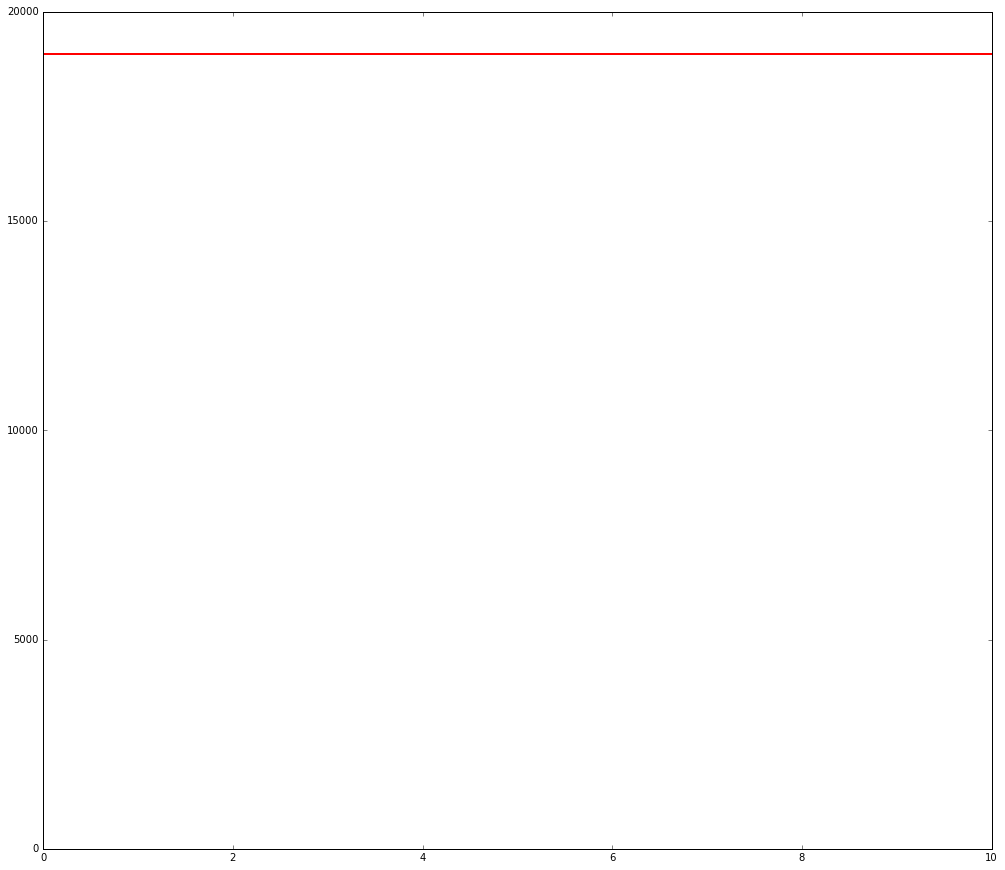

In [9]:
# count total number of catchments for levels 2-10

levels = range(1, 11)
count = []
for level in levels:
    files = glob.glob(r'..\shared\HydroBASINS\without_lakes\hybas_*_lev{0:02}_v1c.shp'.format(level))

    feature_count = 0
    for f in files:
        with fiona.open(f) as source:
            feature_count += len(source)
    count.append(feature_count)
        
    print('Level: {0}, Feature Count: {1}'.format(level, feature_count))

plt.plot(levels, count)
plt.plot([0, 10], [19000, 19000], 'r-', lw=2)


In [5]:
# test
n = convert_basins_to_graph(info['gr'])
nodes=dict(n.nodes(data=True))

shape=sl.geometry.shape(nodes[nodes.keys()[0]]['feature']['geometry'])
shape   

IndexError: list index out of range

In [ ]:
(w, h) = get_wh(shape)

print('w', w)
print('h', h)

In [ ]:
basins_wh = []
basins_wh_min = []
basins_wh_max = []
basins_count = []


for basins in basins_per_level:
    whs = [get_wh(sl.geometry.shape(basin['geometry'])) for basin in basins]
    max_wh = np.max([max(whi) for whi in whs])
    min_wh = np.min([min(whi) for whi in whs])
    count = len(basins)
    wh = 0.5*(max_wh+min_wh)
    basins_wh_min.append(min_wh)
    basins_wh_max.append(max_wh)
    basins_wh.append(wh)
    basins_count.append(count)
    print(min_wh, wh, max_wh, count)

In [ ]:
# show number of catchments per level + maximum Width / Height
min_wh_values = []
max_wh_values = []
wh_values = []
average_wh_values = []
catchment_count = []
for i in np.arange(0.2, 9.0, 0.2):
    selection = list(get_leaves_smaller_than('61', i, i))
    
    wh = [get_wh(sl.geometry.shape(nodes[basin]['feature']['geometry'])) for basin in selection]
    max_wh = np.max([max(whi) for whi in wh])
    min_wh = np.min([min(whi) for whi in wh])
    average_wh_values.append(0.5*(min_wh+max_wh))
    count = len(basins)

    count = len(selection)
    print(min_wh, i, max_wh, count)
    catchment_count.append(count)
    max_wh_values.append(max_wh)
    min_wh_values.append(min_wh)
    
    wh_values.append(i)

In [ ]:
plt.plot(catchment_count, wh_values, 'ob-', linewidth=2.0)
plt.plot(catchment_count, average_wh_values, 'b-')
plt.plot(catchment_count, min_wh_values, 'b--')
plt.plot(catchment_count, max_wh_values, 'b--')


# plt.errorbar(wh_values, catchment_count,xerr=[min_error_wh_values, max_error_wh_values], fmt='.')


# plt.errorbar(wh_values, catchment_count, xerr=error_wh_values)

plt.plot(basins_count, basins_wh, 'or-', linewidth=2.0)
plt.plot(basins_count, basins_wh_min, 'r--')
plt.plot(basins_count, basins_wh_max, 'r--')

# plt.errorbar(basins_wh, basins_count, xerr=[basins_wh_error_min,basins_wh_error_max])


In [ ]:
large_nodes = list((node for (node, data) in n.nodes(data=True) 
                    if geometry_larger_than(sl.geometry.shape(data['feature']['geometry']), max_w, max_h)))
s = n.subgraph(large_nodes)
print(len(large_nodes))
leaves=[node for node,data in s.out_degree().items() if data==0]
print(len(list(leaves)))
s = n.subgraph(leaves)


Try to open it in http://visjs.org/examples/network/15_dot_language_playground.html

In [ ]:
nx.write_dot(n, r"..\output\catchment_pfafids.dot")
print(len(n.nodes()))

In [ ]:
pos = nx.spring_layout(nx.Graph(n), iterations=500)

In [1]:
import math

node_areas=[data['area'] for node,data in n.nodes(data=True)]

node_sizes=[math.log(a)*100 for a in node_areas]

nx.draw_networkx_nodes(n, pos, node_color=node_areas, node_size=node_sizes, cmap=plt.cm.Blues, alpha=0.85)
_ = nx.draw_networkx_edges(n, pos, alpha=0.2)
# _ = nx.draw_networkx_labels(n, pos, font_size=15)

# nx.draw_networkx_nodes(s, pos, node_size=20, cmap=plt.cm.Reds, alpha=0.85)


NameError: name 'n' is not defined

In [ ]:
leaf_basins = list(s.nodes(data=True))

fig = plt.figure()
axes = plt.axes()
axes.set_aspect('equal', 'datalim')

for f in leaf_basins:
    geom = sl.geometry.shape(f[1]['feature']['geometry'])
    draw(geom, alpha=0.5)

plt.show()  


In [ ]:
print(n.predecessors('5642'))
print(n.successors('5642'))

s = n.subgraph(n.successors('5642')+['5642','564','56424','5648','56480'])

node_areas=[data['area'] for node,data in s.nodes(data=True)]
node_sizes=[a*5 for a in node_areas]

pos = nx.spring_layout(nx.Graph(s), iterations=500, scale=10.0)

nx.draw_networkx_nodes(s, pos, node_color=node_areas, node_size=node_sizes, cmap=plt.cm.Blues, alpha=0.85)
_ = nx.draw_networkx_edges(s, pos, alpha=0.2)
_ = nx.draw_networkx_labels(s, pos, font_size=15)    

Select basins where Area + Width/Height ratio are just less than a given parameter

In [ ]:
def get_catchments_using_area(graph, root, max_area):
    children = graph.successors(root)
    for child in children:
        graph[child]
    
print(n.predecessors('5642'))
print(n.successors('5642'))
